## Prediction of Gout from patient's Chief Complaint Corpa

## Question: Is this patient potentially in need of treatment for Gout?

##  Data
The data is found in the MIMIC-III (Medical Information Mart for Intensive Care III) database.  Details can be found at https://physionet.org/content/emer-complaint-gout/1.0/.   Acces to the database may be requested at (https://mimic.physionet.org/gettingstarted/access/).  The data is contained in 2 csv files from years 2019 and 2020.

### Import Data

In [1]:
import pandas as pd
df = pd.read_pickle("noGoutTerm.csv")
df.shape

(8275, 2)

### Split data into training and test sets

In [2]:
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
    
    # split data into training and validation sets
X_train, X_test, y_train, y_test = train_test_split(
    df['corpus'],                                     
    df.target,                                       
    test_size=0.30,                                   
    stratify=df.target,                                # Stratify the imbalanced target
    random_state=1,                                    # Constant seed for reproducibility
    shuffle=True                                       # Set for the 'statify' parameter
)

###  Convert training data to integer vectors with TF-IDF, weighted, by importance.

In [3]:
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder

    # Vectoring the corpus from string to int, the TFidf method will weight the keywords
tfidf_vectorizer = TfidfVectorizer(stop_words='english')
X_train = tfidf_vectorizer.fit_transform(X_train)
X_test = tfidf_vectorizer.transform(X_test)

### Encode the test target values: necessary for calculating ROC Curve

In [4]:
labelencoder=LabelEncoder()                     # Simple direct encoding from string to int
E_y_test = labelencoder.fit_transform(y_test)

## Instantiate Models with default hyperparamters

In [5]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

# Dict of the 6 models to be tested and tuned
models_untuned = [
{
    'label': 'Logistic Regression',
    'model': LogisticRegression(random_state=1),     # see the random state for reproducabity during tuning
    'grid' : {}                                      # default hyperparameters
},  
{   'label' : 'Naive Bayes',
    'model' : MultinomialNB(),
    'grid' : {}
},  
{   'label' : 'SVM',
    'model' : svm.SVC(random_state=1),
    'grid' : {}
},
    {   'label' : 'KNNeighbors',     
    'model' : KNeighborsClassifier(),
    'grid' : {}
},   
{   'label': 'Gradient Boosting',
    'model': GradientBoostingClassifier(random_state=1),
    'grid' : {}
}, 
{   'label' : 'Random Forest',   
     'model' : RandomForestClassifier(random_state=1),
    'grid' : {}
}
]

## Create Methods used for training and testing of models

In [6]:
#Load Libraries for the mothods that follow

from sklearn import metrics
import matplotlib.pyplot as plt
import imblearn
from imblearn.pipeline import make_pipeline, Pipeline
from numpy import mean
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.metrics import plot_confusion_matrix

### Method: fit_models
Fits multiple models

<b><i>Returns</b></i> ROC_AUC score and fitted model

In [7]:
import warnings
warnings.filterwarnings('ignore')

def fit_models(model):
    param_grid = model['grid']
    over = RandomOverSampler(sampling_strategy=0.1,random_state=1)    # Data is highly imbalanced, limit oversampling
    under = RandomUnderSampler(sampling_strategy=0.5,random_state=1)  # Complete the class balance with undersampling
    steps = [('o', over), ('u', under), ('m', model['model'])]  # apply the combo under/over sampling for balance
    pipeline = Pipeline(steps=steps)
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
    grid = GridSearchCV(pipeline, param_grid, scoring='roc_auc',      # Wrap a gridsearch with a 10-fold split
                        cv=cv)
    grid.fit(X_train, y_train)
    if model['label'] == 'SVM':
        predict = grid.decision_function(X_test)                      # Test the SVM model, requires 'decision_function' 
    else:
        predict = grid.predict_proba(X_test)[:, 1]                    # Test remaining models with predict_proba
    score = metrics.roc_auc_score(y_test, predict)
    return score, grid

### Method: single_fit
Fits a single model for use during the tuning stage

<b><i>Returns</b></i> ROC AUC score, fitted model, best parameters, and cross validation results

In [8]:
import warnings
warnings.filterwarnings('ignore')

def single_fit(model, parameters, label='none'):
    over = RandomOverSampler(sampling_strategy=0.1,random_state=1)
    under = RandomUnderSampler(sampling_strategy=0.5,random_state=1)
    steps = [('o', over), ('u', under), ('m', model)]
    pipeline = Pipeline(steps=steps)
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
    grid = GridSearchCV(pipeline, param_grid=parameters, scoring='roc_auc', cv=cv)  #scoring is roc_auc
    grid.fit(X_train, y_train)
    if label == 'SVM':
        predict = grid.decision_function(X_test)
    else:
        predict = grid.predict_proba(X_test)[:, 1]
    score = metrics.roc_auc_score(y_test, predict)                                 # consistent scoring = roc_auc
    return score, grid, grid.best_params_, (pd.DataFrame(grid.cv_results_))

### Method:  ROC_overlap
Plots all models on single graph

In [9]:
def ROC_overlap(models):
    plt.figure(figsize=(11,5))
    allAUC = []

# Below for loop iterates through your models list
    for m in models:
        model = m['model']                  # Repeat fit_models code: unable to pass fit model method to method
        param_grid = m['grid']
        over = RandomOverSampler(sampling_strategy=0.1, random_state=1)
        under = RandomUnderSampler(sampling_strategy=0.5, random_state=1)
        steps = [('o', over), ('u', under), ('m', model)]
        pipeline = Pipeline(steps=steps)
        cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
        grid = GridSearchCV(pipeline, param_grid, scoring='roc_auc', cv=cv)

        if m['label'] == 'SVM':                                 # Specific to SVM prediction: decision_function
            test_predict_label = grid.fit(X_train, y_train).decision_function(X_test)
            fpr, tpr, threshold = metrics.roc_curve(E_y_test, test_predict_label)
        else:
            grid.fit(X_train, y_train)                         
            y_pred=grid.predict(X_test)                        
            fpr, tpr, thresholds = metrics.roc_curve(E_y_test, grid.predict_proba(X_test)[:,1])
        auc = metrics.auc(fpr,tpr)
        allAUC.append(auc)

# Now, plot the computed values
        plt.plot(fpr, tpr, label='%s ROC (area = %0.2f)' % (m['label'], auc))
# Custom settings for the plot 
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('1-Specificity(False Positive Rate)')
    plt.ylabel('Sensitivity(True Positive Rate)')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()   # Display

### Method: plotConfusion
Plots the confustion matrix of all models in grouped subplots

In [10]:
# Plot the confusion matrix for all models

def plotConfusion(models, param_grid = {}):
    allModels = []
    for m in models_untuned:
        model = m['model'] # select the model
        over = RandomOverSampler(sampling_strategy=0.1, random_state=1)
        under = RandomUnderSampler(sampling_strategy=0.5, random_state=1)
        steps = [('o', over), ('u', under), ('m', model)]
        pipeline = Pipeline(steps=steps)
        cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=0)
        model = GridSearchCV(pipeline, param_grid, scoring='roc_auc', cv=cv)
        model.fit(X_train, y_train) # train the model
        allModels.append(model)
    
    fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(10,5))

    for cls, ax in zip(allModels, axes.flatten()):
        plot_confusion_matrix(cls, X_test, y_test, ax=ax, cmap='Blues')
        ax.set_title(cls.estimator['m'])
    plt.tight_layout()  
    plt.show()

## Train and Test Models w/default hyperparameters

#### ROC AUC results from base (untuned) models

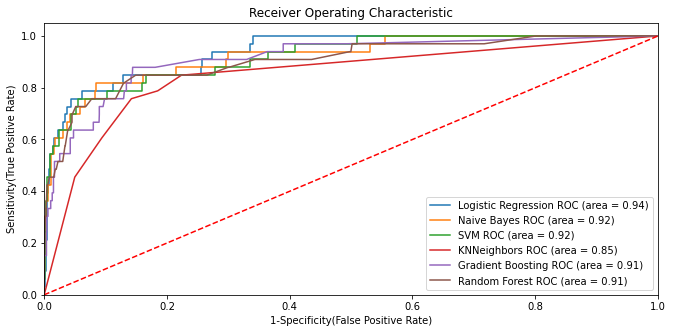

In [11]:
#Run the plot for all the models
grid = {}                           # default parameters
ROC_overlap(models_untuned)

### Confusion Matrix from base (untuned) models

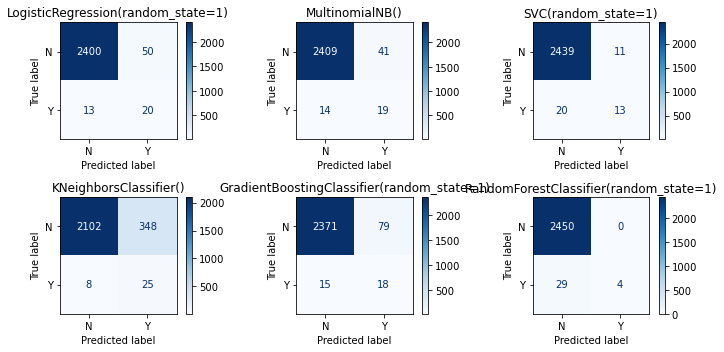

In [12]:
# Plot the confusion matrix for all models with default hyperparameters

plotConfusion(models_untuned)

### Summary of scores for base (untuned) model

In [13]:
a_scores = []
a_labels = []
print("Base Classifiers: ROC AUC")
for m in models_untuned:
    a_labels.append(m['label'])
    score, grid = fit_models(m)
    a_scores.append(score*100)
df_untuned = pd.DataFrame(columns = {'model', 'score'})
df_untuned['model']=a_labels
df_untuned['score']=a_scores
df_untuned

Base Classifiers: ROC AUC


,model,score
0,Logistic Regression,93.794682
1,Naive Bayes,92.226345
2,SVM,91.996289
3,KNNeighbors,84.988868
4,Gradient Boosting,91.289425
5,Random Forest,90.529375


### Plot the summary of ROC AUC scores of Base Classifiers - prior to hyperparameter tuning

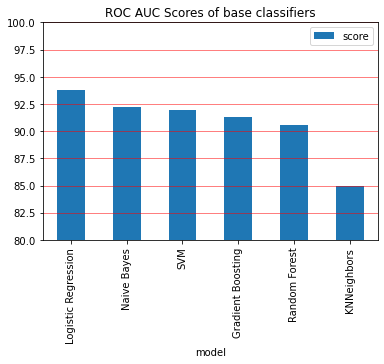

In [14]:
ax = df_untuned.sort_values(by='score', ascending=False).plot.bar(x='model', y='score', rot=0)
plt.ylim([80, 100])
plt.xticks(rotation=90)
plt.grid(color='red', linewidth=1, axis='y', alpha=0.5)
plt.title("ROC AUC Scores of base classifiers")
plt.show()

## Hyperparameter Tuning

The models were tested for various hyperparameters to potentially increase accuracies beyond optimization techniques.

### Tune the Logistic Regression model

In [29]:
# Logistic Regression Grid
# not included such as 'dual', 'tol', and 'fit_intercept' unnecessary for this project

LG_grid = {
    'm__solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag'],
    'm__penalty': ['l2', 'l2', 'elasticnet', 'none'],
    'm__class_weight' : ['balanced', 'None'],
#    'm__class_weight' : [{0:0.1, 1:0.99}],
    'm__C': [0.1, 1, 10],
    'm__max_iter': [100, 4000, 8000],
    'm__multi_class' : ['auto', 'ovr', 'multinomial'],
    'm__random_state': [1]
}

In [30]:
score, grid, parameters, results = single_fit(LogisticRegression(), LG_grid)
print(score)
print(parameters)

0.938973407544836
{'m__C': 1, 'm__class_weight': 'balanced', 'm__max_iter': 100, 'm__multi_class': 'auto', 'm__penalty': 'l2', 'm__random_state': 1, 'm__solver': 'liblinear'}


### Results Logistic Regression
Looking at the best parameters listed by the grid search, the parameters that are not default values are the class_weight = 'balanced',  solver = 'liblinear', multi_class = 'auto'.  The remaining parameters are the default parameters.

Results: The following parameters will be included in the tuned model - class_weight = 'balanced',  solver = 'liblinear', multi_class = 'auto'

### Tune the Naive Bayes model

In [31]:
# Create grid for naive bayes

NB_grid = {
    'm__alpha' : [0, 1.0],
    'm__fit_prior' : ['True','False']
}

#{ 'm__var_smoothing': [np.logspace(0,-9, num=100)]}

In [32]:
score, grid, parameter, results = single_fit(MultinomialNB(), NB_grid)
print(score)
print(parameter)

0.9222634508348794
{'m__alpha': 1.0, 'm__fit_prior': 'True'}


### Results Naive Bayes
Take a look at the details in the results, we see the most influential parameter is the alpha with the best value = 1, the bottom 2 rows are alpha=1, the top 2 are alpha=0, we see the test scores on average are much higher with a value of 1 which happens to be the default paramter.  The fit_prior best parameter did not change results therefore the grid search selected the default value of 'True' as the best parameter.

Results: no additional tuning will improve the results, the default parameters are the best

### Tune SVM model

In [33]:
# SVM Grid

SVM_grid = {
    'm__gamma': [1, 0.1, 0.01],
    'm__degree': [1,2,3],
    'm__class_weight':['balanced','None'],
    'm__decision_function_shape':['ovr','ovo'],
    'm__random_state' : [1]
}

In [34]:
score, grid, parameter, results = single_fit(svm.SVC(), SVM_grid, 'SVM')
print(score)
print(parameter)

0.9223252937538652
{'m__class_weight': 'balanced', 'm__decision_function_shape': 'ovr', 'm__degree': 1, 'm__gamma': 1, 'm__random_state': 1}


### Tune KNN model

In [35]:
KNN_grid = {
    'm__n_neighbors': (1,10, 1),
    'm__leaf_size': (2,40,1),
    'm__p': (1,2),
    'm__weights': ('uniform', 'distance'),
    'm__metric': ('minkowski', 'chebyshev'),
}

In [36]:
score, grid, parameter, results = single_fit(KNeighborsClassifier(), KNN_grid)
print(score)
print(parameter)

0.8655225726654299
{'m__leaf_size': 2, 'm__metric': 'minkowski', 'm__n_neighbors': 10, 'm__p': 2, 'm__weights': 'distance'}


   ### Tune Gradient Boost

In [37]:
GBA_grid = {
    'm__n_estimators': [20,30,40,50,60,70,80],
    'm__random_state' : [1]
}

In [38]:
score, grid, parameter, results = single_fit(GradientBoostingClassifier(random_state=1), GBA_grid)
print(score)
print(parameter)

0.9095547309833025
{'m__n_estimators': 60, 'm__random_state': 1}


### Tune Random Forest Classifier

In [39]:
RFC_grid = {
    'm__n_estimators': [2500, 5000],
    'm__max_features' : ['auto', 'sqrt', 'log2'],
    'm__max_features' : ['sqrt'],
    'm__random_state' : [1]
}

In [40]:
score, grid, parameter, results = single_fit(RandomForestClassifier(), RFC_grid)
print(score)
print(parameter)

0.9177118119975263
{'m__max_features': 'sqrt', 'm__n_estimators': 5000, 'm__random_state': 1}


### Hyperparameters to tune the models

In [15]:
L_grid = {
    'm__solver': ['liblinear'],
    'm__class_weight': ['balanced'],
    'm__max_iter': [100],
    'm__multi_class' : ['auto'],
    'm__random_state': [1],
    'm__C': [1],
    'm__penalty': ['l2'],
}
N_grid = {
    'm__alpha': [1.0], 
    'm__fit_prior': ['True']
}
SV_grid = {
    'm__gamma': [1],
    'm__degree': [1],
    'm__class_weight': ['balanced'],
    'm__random_state': [1],
    'm__decision_function_shape': ['ovr']
}
KN_grid = {
    'm__leaf_size': [2],
    'm__metric': ['minkowski'], 
    'm__n_neighbors': [10], 
    'm__p': [2], 
    'm__weights': ['distance']
}
GB_grid = {   
    'm__n_estimators': [80], 
    'm__random_state': [1]
}, 
RF_grid = { 
    'm__max_features': ['sqrt'],
    'm__n_estimators': [5000],
    'm__random_state': [1]

}

### Create tuned models

In [16]:
    # Models after hyperparameters tuned
models_tuned = [
{
    'label': 'Logistic Regression',
    'model': LogisticRegression(),
    'grid' : L_grid
},
{
    'label' : 'Naive Bayes',
    'model' : MultinomialNB(),
    'grid'  : N_grid
},
{
    'label' : 'SVM',
    'model' : svm.SVC(),
    'grid'  : SV_grid
},
{   'label' : 'KNNeighbors',     
    'model' : KNeighborsClassifier(),
    'grid'  : KN_grid
},
{   'label': 'Gradient Boosting',
    'model': GradientBoostingClassifier(),
    'grid' : GB_grid
}, 
{   'label' : 'Random Forest',   
     'model' : RandomForestClassifier(),
    'grid' : RF_grid
}
]

In [17]:
a_scores = []
a_labels = []

for m in models_tuned:
    a_labels.append(m['label'])
    score, grid = fit_models(m)
    a_scores.append(score*100)
df_tuned = pd.DataFrame(columns = {'model', 'score'})
df_tuned['model']=a_labels
df_tuned['score']=a_scores
df_tuned

,model,score
0,Logistic Regression,93.897341
1,Naive Bayes,92.226345
2,SVM,92.232529
3,KNNeighbors,86.552257
4,Gradient Boosting,91.137910
5,Random Forest,91.771181


In [18]:
df3 = df_untuned
df3 = df3.rename(columns={'score':'untuned score'})

In [19]:
print(df3)
print(df_tuned)

                 model  untuned score
0  Logistic Regression      93.794682
1          Naive Bayes      92.226345
2                  SVM      91.996289
3          KNNeighbors      84.988868
4    Gradient Boosting      91.289425
5        Random Forest      90.529375
                 model      score
0  Logistic Regression  93.897341
1          Naive Bayes  92.226345
2                  SVM  92.232529
3          KNNeighbors  86.552257
4    Gradient Boosting  91.137910
5        Random Forest  91.771181


In [20]:
df_tuned

,model,score
0,Logistic Regression,93.897341
1,Naive Bayes,92.226345
2,SVM,92.232529
3,KNNeighbors,86.552257
4,Gradient Boosting,91.137910
5,Random Forest,91.771181


In [21]:
df_tuned['untuned score'] = ''
df
df_tuned

,model,score,untuned score
0,Logistic Regression,93.897341,
1,Naive Bayes,92.226345,
2,SVM,92.232529,
3,KNNeighbors,86.552257,
4,Gradient Boosting,91.137910,
5,Random Forest,91.771181,


In [22]:
df_final = df_tuned.merge(df3, how = 'left', on='model')

In [23]:
df_final = df_final.drop(['untuned score_x'], axis=1).rename(columns = {'untuned score_y': 'untuned score',
                                                                       'score':'tuned score'})

In [24]:
df_final

,model,tuned score,untuned score
0,Logistic Regression,93.897341,93.794682
1,Naive Bayes,92.226345,92.226345
2,SVM,92.232529,91.996289
3,KNNeighbors,86.552257,84.988868
4,Gradient Boosting,91.137910,91.289425
5,Random Forest,91.771181,90.529375


<Figure size 2160x360 with 0 Axes>

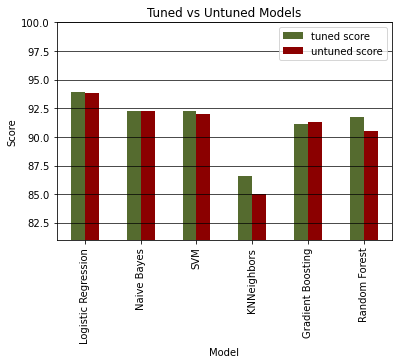

In [25]:
plt.figure(figsize=(30,5))

df_final.plot.bar(x="model", y=["tuned score", "untuned score"],color = ['darkolivegreen', 'darkred'])
plt.ylim([81, 100])
plt.xticks(rotation=90)
plt.grid(color='black', linewidth=1, axis='y', alpha=0.7)
plt.title("Tuned vs Untuned Models")
plt.xlabel("Model")
plt.ylabel("Score")
plt.show()

<Figure size 2160x360 with 0 Axes>

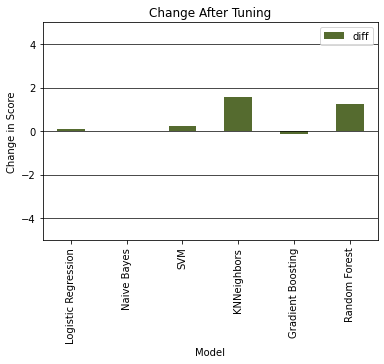

In [26]:

df_tuned['diff']=df_final['tuned score'] - df_final['untuned score']
import matplotlib.pyplot as plt


plt.figure(figsize=(30,5))

df_tuned.plot.bar(x="model", y="diff",color = 'darkolivegreen')
plt.ylim([-5, 5])
plt.xticks(rotation=90)
plt.grid(color='black', linewidth=1, axis='y', alpha=0.7)
plt.title("Change After Tuning")
plt.xlabel("Model")
plt.ylabel("Change in Score")
plt.show()

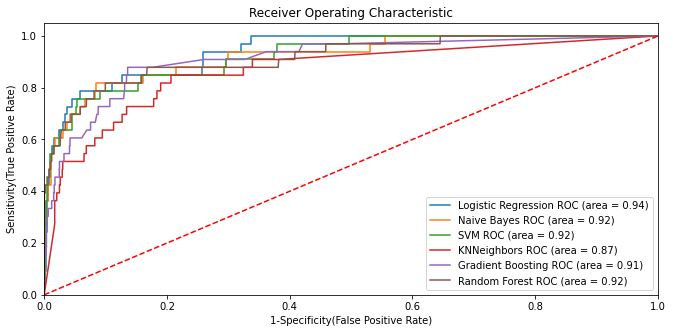

In [27]:
tuned_auc_scores = ROC_overlap(models_tuned)

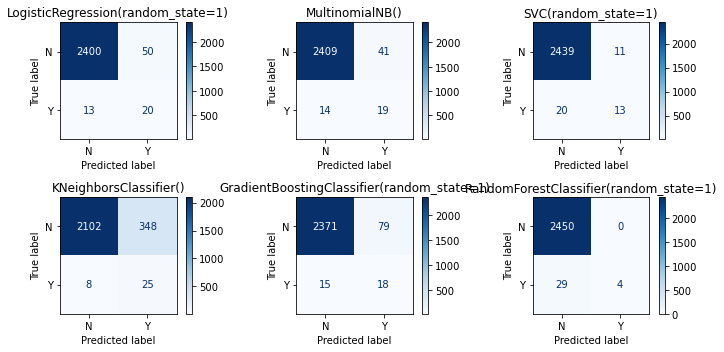

In [28]:
# Plot the confusion matrix for all models

plotConfusion(models_tuned)